# Deep Learning: Sentiment Analysis

- In this unit, we will build a deep-learning-based sentiment classifier on the movie reviews from `ntlk`.

![](../images/keras-workflow.png)

## Prepare Data

In [1]:
import numpy as np
import nltk
from nltk.corpus import movie_reviews
import random

In [2]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

documents = [(text, 1) if label == "pos" else (text, 0)
             for (text, label) in documents]

random.shuffle(documents)

In [3]:
documents[1]

('jacques tati \' s 1953 classic " les vacances de m . hulot " ( also known as " mr . hulot \' s vacation , " in english ) ought to be the textbook on how to do non ? dialogue comedy in film . the characters hardly ever speak to each other directly , and the film operates on the paper ? thin premise that monsieur hulot , played by tati himself , is awkward and clumsy and generally manages to annoy the other guests at the beach resort hotel where he is taking a week \' s vacation . yet the film had me beside myself laughing more consistently than any in recent memory . part of the reason the film works so well is the clever setup for the various gags . slapstick has often been regarded as an unsophisticated and even crude form of comedy , but i think part of the reason for this is that it often seems forced : you can only see movie characters start running after something and then crash face - first into a pole so many times before you start to wonder what all these poles are doing ther

## Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(documents,
                                       test_size=0.1,
                                       random_state=42)
print(len(train_set), len(test_set))

1800 200


## Prepare Input and Output Tensors

- For text vectorization, we will implement two alternatives:
    - Texts to Matrix: **One-hot encoding** of texts (similar to bag-of-words model)
    - Texts to Sequences: **Integer encoding** of all word tokens in texts and we will learn token **embeddings** along with the networks

- Important Steps:
    - Split data into **X** (texts) and **y** (sentiment labels)
    - Initialize `Tokenizer`
    - Use the `Tokenizer` for `text_to_sequences()` or `text_to_matrix()`
    - Padding the sequences to uniform lengths if needed (this can be either the max length of the sequences or any arbitrary length)
    

In [5]:
## Dependencies
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Bidirectional, Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import GlobalAveragePooling1D

In [6]:
## Split data into X (texts) and y (labels)
texts = [n for (n, l) in train_set]
labels = [l for (n, l) in train_set]

In [7]:
print(len(texts))
print(len(labels))

1800
1800


### Tokenizer

- Important Notes:
    - We set the `num_words` at **10000**, meaning that the `Tokenizer` will automatically include only the most frequent **10000** words in the later text vectorization.
    - In other words, when we perform `text_to_sequences()` later, the `Tokenizer` will automatically remove words that are NOT in the top 10000 words.
    - However, the `tokenizer` still keeps the integer indices of all the words in the training texts (i.e., `tokenizer.word_index`)

In [8]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts)

### Vocabulary

- When computing the vocabulary size, the plus 1 is due to the addition of the padding token.
- If `oov_token` is specified, then the vocabulary size needs to be added one more.
- When `oov_token` is specified, the unknown word tokens (i.e., words that are not in the top 10000 words) will be replaced with this `oov_token` token, instead of being removed from the texts.

In [9]:
# determine the vocabulary size
# vocab_size = len(tokenizer.word_index) + 1
vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 10001


In [10]:
list(tokenizer.word_index.items())[:20]

[('the', 1),
 ('a', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ("'", 6),
 ('is', 7),
 ('in', 8),
 ('s', 9),
 ('it', 10),
 ('that', 11),
 ('as', 12),
 ('with', 13),
 ('for', 14),
 ('his', 15),
 ('this', 16),
 ('film', 17),
 ('i', 18),
 ('he', 19),
 ('but', 20)]

In [11]:
len(tokenizer.word_index)

37910

## Define X and Y (Text Vectorization)

### Method 1: Text to Sequences

- Text to sequences (integers)
- Pad sequences

#### Text to Sequences

In [12]:
texts_ints = tokenizer.texts_to_sequences(texts)

In [13]:
print(len(texts[1000].split(' ')))  ## original text word number
print(len(texts_ints[1000]))  ## sequence token number

1947
1624


#### Padding

- When dealing with texts and documents, padding each text to the **maximum length** may not be ideal. 
- For example, for sentiment classification, it is usually the case that authors would more clearly reveal/highlight his/her sentiment at the end of the text. 
- Therefore, we can specify an arbitrary `max_len` in padding the sequences to (a) reduce the risk of including too much noise in our model, and (b) speed up the training steps.

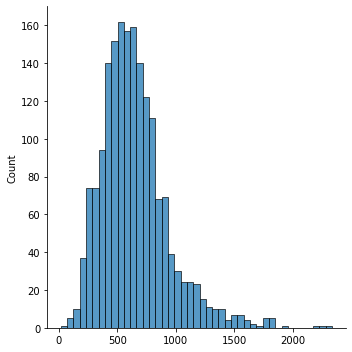

In [14]:
## Check the text len distribution
texts_lens = [len(n) for n in texts_ints]
texts_lens
import seaborn as sns
sns.displot(texts_lens)

In [15]:
## Find the maxlen of the texts
max_len = texts_lens[np.argmax(texts_lens)]
max_len

2334

- In this tutorial, we consider only the **final** 400 tokens of each text, using the following parameters for `pad_sequences()`.
    - We keep the final 400 tokens from the text (`truncating='pre'`).
    - If the text is shorter than 400 tokens, we pad the text to 400 tokens at the beginning of the text (`padding='pre'`).

In [16]:
## Padding
max_len = 400
texts_ints_pad = sequence.pad_sequences(texts_ints,
                                        maxlen=max_len,
                                        truncating='pre',
                                        padding='pre')
texts_ints_pad[:10]

array([[1171,   29,   93, ...,  267,   41,   10],
       [  65,  415,   53, ..., 1422,    1,  628],
       [  12,   72,   12, ...,    4,  446, 1934],
       ...,
       [2275,  389,  101, ...,    5,   25,  746],
       [  30,  181,   84, ...,    7,  193,   40],
       [ 179,   14,   53, ...,    4,   11, 1004]], dtype=int32)

In [17]:
## Gereate X and y for training
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(labels)

## Gereate X and y for testing in the same way
X_test_texts = [n for (n, l) in test_set]
X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_texts),
                           maxlen=max_len,
                           padding='pre',
                           truncating='pre')).astype('int32')
y_test = np.array([l for (n, l) in test_set])

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 400)
(1800,)
(200, 400)
(200,)


### Method 2: Text to Matrix (One-hot Encoding/Bag-of-Words)

In [19]:
## Texts to One-Hot Encoding (bag of words)
texts_matrix = tokenizer.texts_to_matrix(texts, mode="binary")
X_train2 = np.array(texts_matrix).astype('int32')
y_train2 = np.array(labels)

## Same for Testing Data
X_test2 = tokenizer.texts_to_matrix(X_test_texts,
                                    mode="binary").astype('int32')
y_test2 = np.array([l for (n, l) in test_set])

In [20]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1800, 10000)
(1800,)
(200, 10000)
(200,)


## Hyperparameters

In [21]:
## A few DL hyperparameters
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128

## Model Definition

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

### Model 1

- Two layers of fully-connected dense layers
- The input is the one-hot encoding of the text from text-to-matrix.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.002.jpeg)

In [23]:
## Model 1
model1 = Sequential()
model1.add(Input(shape=(NUM_WORDS, )))
model1.add(Dense(16, activation="relu", name="dense_layer_1"))
model1.add(Dense(16, activation="relu", name="dense_layer_2"))
model1.add(Dense(1, activation="sigmoid", name="output"))

model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

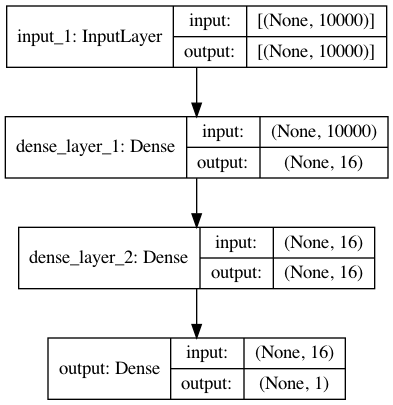

In [24]:
plot_model(model1, show_shapes=True)

In [25]:
history1 = model1.fit(X_train2,
                      y_train2,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 4s - loss: 0.6566 - accuracy: 0.6403 - val_loss: 0.5892 - val_accuracy: 0.7833
Epoch 2/25
12/12 - 0s - loss: 0.4519 - accuracy: 0.9076 - val_loss: 0.4807 - val_accuracy: 0.8306
Epoch 3/25
12/12 - 0s - loss: 0.2788 - accuracy: 0.9653 - val_loss: 0.4001 - val_accuracy: 0.8306
Epoch 4/25
12/12 - 0s - loss: 0.1587 - accuracy: 0.9840 - val_loss: 0.3530 - val_accuracy: 0.8500
Epoch 5/25
12/12 - 0s - loss: 0.0876 - accuracy: 0.9944 - val_loss: 0.3224 - val_accuracy: 0.8694
Epoch 6/25
12/12 - 0s - loss: 0.0482 - accuracy: 0.9993 - val_loss: 0.3089 - val_accuracy: 0.8889
Epoch 7/25
12/12 - 0s - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.3013 - val_accuracy: 0.8861
Epoch 8/25
12/12 - 0s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.3027 - val_accuracy: 0.8694
Epoch 9/25
12/12 - 0s - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.2997 - val_accuracy: 0.8806
Epoch 10/25
12/12 - 0s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.3020 - val_accuracy: 0.8778
Epoch 11/25
12/12 -

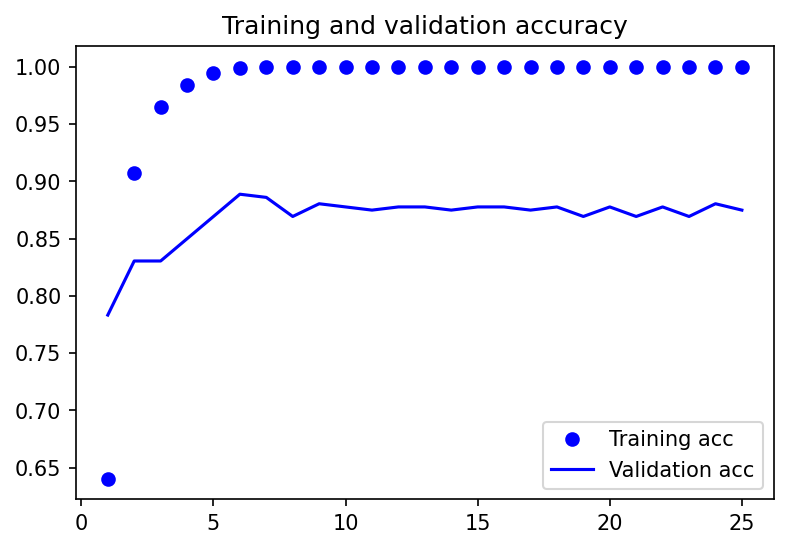

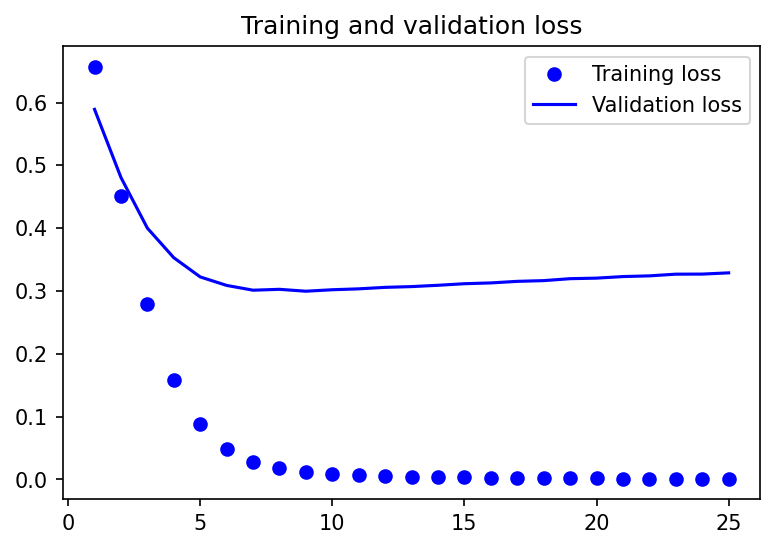

In [26]:
## Plot Training History
plot1(history1)

In [27]:
## Model Evaluation
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.4454 - accuracy: 0.8350


[0.4454449415206909, 0.8349999785423279]

### Model 2

- One Embedding Layer + Two fully-connected dense layers
- The Inputs are the sequences (integers) of texts.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.004.jpeg)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.008.jpeg)

In [28]:
## Model 2
model2 = Sequential()
model2.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model2.add(
    GlobalAveragePooling1D()
)  ## The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
model2.add(Dense(16, activation="relu", name="dense_layer_1"))
model2.add(Dense(16, activation="relu", name="dense_layer_2"))
model2.add(Dense(1, activation="sigmoid", name="output"))

model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

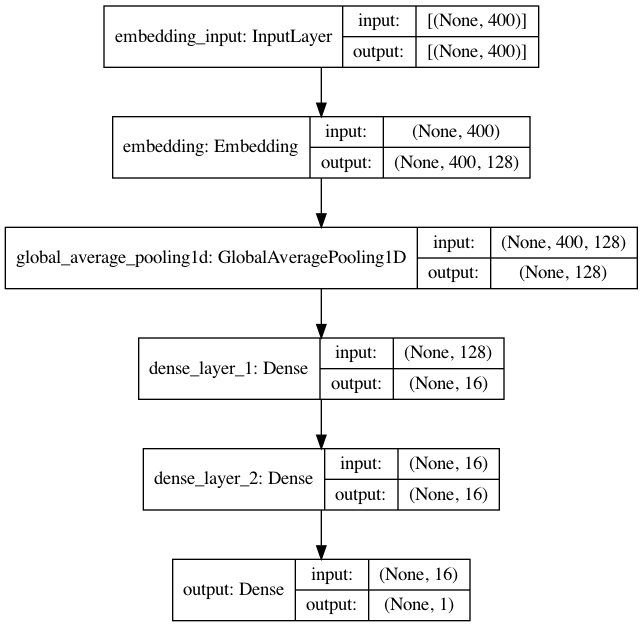

In [29]:
plot_model(model2, show_shapes=True)

In [30]:
history2 = model2.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 1s - loss: 0.6925 - accuracy: 0.5118 - val_loss: 0.6918 - val_accuracy: 0.5194
Epoch 2/25
12/12 - 0s - loss: 0.6887 - accuracy: 0.6465 - val_loss: 0.6889 - val_accuracy: 0.5778
Epoch 3/25
12/12 - 1s - loss: 0.6822 - accuracy: 0.6764 - val_loss: 0.6835 - val_accuracy: 0.6917
Epoch 4/25
12/12 - 1s - loss: 0.6707 - accuracy: 0.8660 - val_loss: 0.6754 - val_accuracy: 0.6667
Epoch 5/25
12/12 - 1s - loss: 0.6503 - accuracy: 0.8361 - val_loss: 0.6587 - val_accuracy: 0.7556
Epoch 6/25
12/12 - 0s - loss: 0.6188 - accuracy: 0.8965 - val_loss: 0.6408 - val_accuracy: 0.6972
Epoch 7/25
12/12 - 0s - loss: 0.5739 - accuracy: 0.9028 - val_loss: 0.6061 - val_accuracy: 0.7583
Epoch 8/25
12/12 - 0s - loss: 0.5121 - accuracy: 0.9292 - val_loss: 0.5676 - val_accuracy: 0.7722
Epoch 9/25
12/12 - 0s - loss: 0.4373 - accuracy: 0.9444 - val_loss: 0.5257 - val_accuracy: 0.7917
Epoch 10/25
12/12 - 0s - loss: 0.3557 - accuracy: 0.9611 - val_loss: 0.4756 - val_accuracy: 0.8111
Epoch 11/25
12/12 -

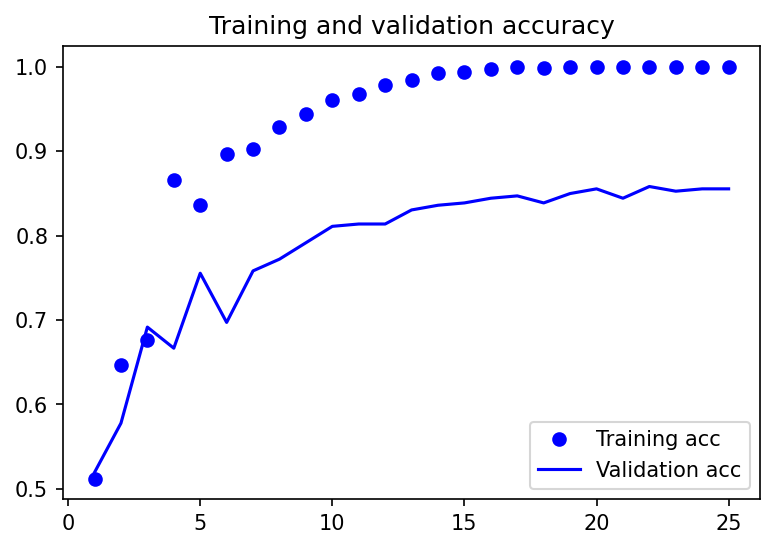

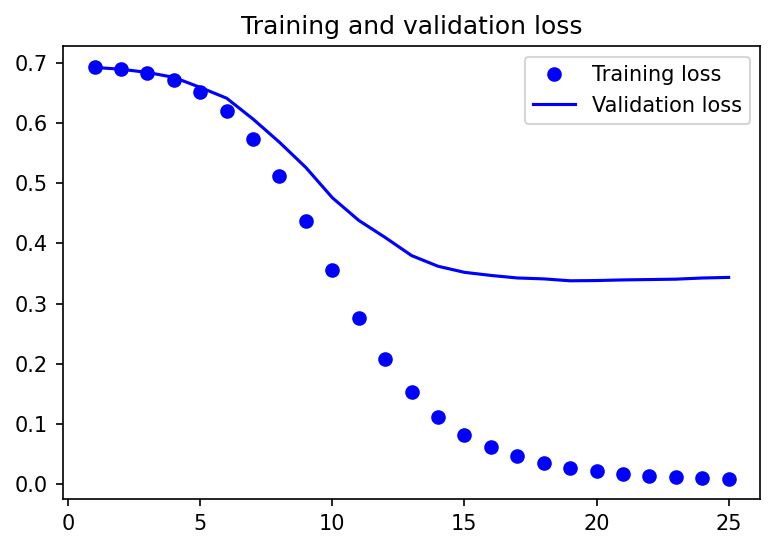

In [31]:
plot1(history2)

In [32]:
model2.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.3942 - accuracy: 0.8300


[0.39421090483665466, 0.8299999833106995]

## Issues of Word/Character Representations

- Generally speaking, we can train our **word embeddings** along with the downstream NLP task (e.g., the sentiment classification in our current case).
- Another common method is to train the word embeddings using unsupervised methods on a large amount of data and apply the pre-trained word embeddings to the current downstream NLP task. Typical methods include word2vec (CBOW or skipped-gram, GloVe etc). We will come back to these unsupervised methods later.

## Sequence Models

### Model 3

- One Embedding Layer + LSTM + Dense Layer
- Input: the text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.012.jpeg)

In [33]:
## Model 3
model3 = Sequential()
model3.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model3.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation="sigmoid"))

model3.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

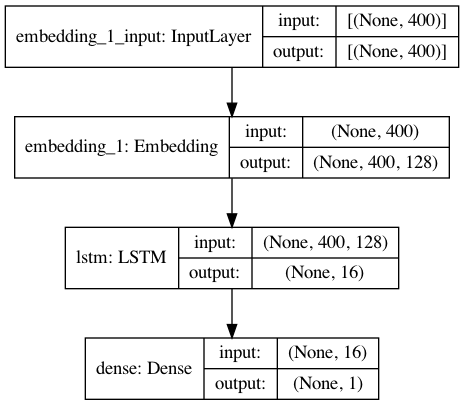

In [34]:
plot_model(model3, show_shapes=True)

In [35]:
history3 = model3.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 9s - loss: 0.6926 - accuracy: 0.5222 - val_loss: 0.6925 - val_accuracy: 0.4944
Epoch 2/25
12/12 - 5s - loss: 0.6800 - accuracy: 0.7646 - val_loss: 0.6890 - val_accuracy: 0.5528
Epoch 3/25
12/12 - 5s - loss: 0.6519 - accuracy: 0.8056 - val_loss: 0.6767 - val_accuracy: 0.5611
Epoch 4/25
12/12 - 5s - loss: 0.5615 - accuracy: 0.8271 - val_loss: 0.6082 - val_accuracy: 0.6806
Epoch 5/25
12/12 - 5s - loss: 0.4255 - accuracy: 0.8535 - val_loss: 0.5526 - val_accuracy: 0.7361
Epoch 6/25
12/12 - 5s - loss: 0.3307 - accuracy: 0.9389 - val_loss: 0.5040 - val_accuracy: 0.7556
Epoch 7/25
12/12 - 4s - loss: 0.2426 - accuracy: 0.9563 - val_loss: 0.5287 - val_accuracy: 0.7667
Epoch 8/25
12/12 - 5s - loss: 0.1845 - accuracy: 0.9826 - val_loss: 0.5505 - val_accuracy: 0.7389
Epoch 9/25
12/12 - 5s - loss: 0.1320 - accuracy: 0.9875 - val_loss: 0.6146 - val_accuracy: 0.7472
Epoch 10/25
12/12 - 5s - loss: 0.1110 - accuracy: 0.9833 - val_loss: 0.5731 - val_accuracy: 0.7500
Epoch 11/25
12/12 -

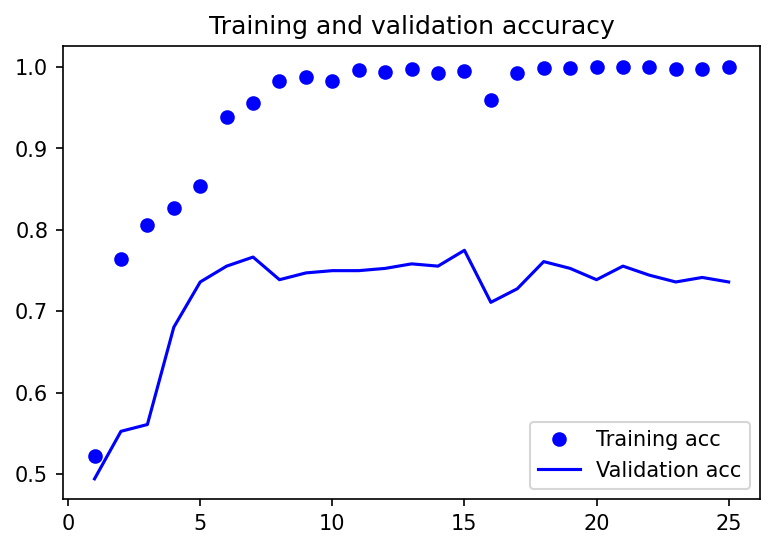

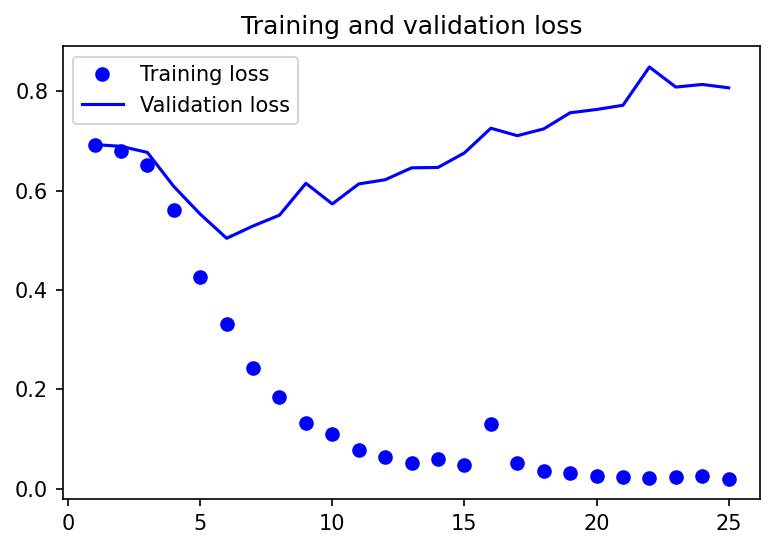

In [36]:
plot1(history3)

In [37]:
model3.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.6608 - accuracy: 0.8000


[0.6607560515403748, 0.800000011920929]

### Model 4

- One Embedding Layer + Two Stacked LSTM + Dense Layer
- Inputs: text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.013.jpeg)

In [38]:
## Model 4
model4 = Sequential()
model4.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model4.add(LSTM(16, return_sequences=True, dropout=0.2,
                recurrent_dropout=0.2))  #)
model4.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1, activation="sigmoid"))

model4.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

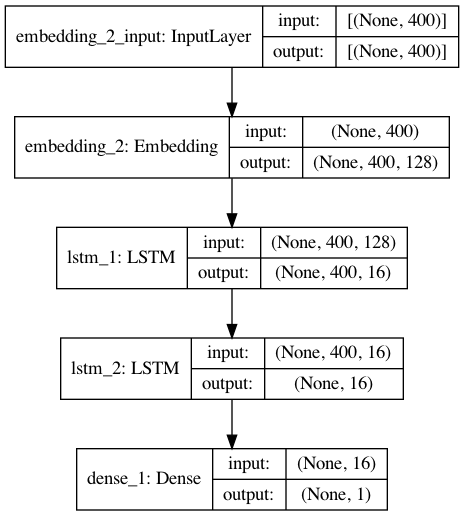

In [39]:
plot_model(model4, show_shapes=True)

In [40]:
history4 = model4.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25
12/12 - 15s - loss: 0.6929 - accuracy: 0.5181 - val_loss: 0.6921 - val_accuracy: 0.5389
Epoch 2/25
12/12 - 9s - loss: 0.6846 - accuracy: 0.6708 - val_loss: 0.6876 - val_accuracy: 0.5556
Epoch 3/25
12/12 - 8s - loss: 0.6468 - accuracy: 0.7715 - val_loss: 0.6575 - val_accuracy: 0.6361
Epoch 4/25
12/12 - 9s - loss: 0.4866 - accuracy: 0.8431 - val_loss: 0.5764 - val_accuracy: 0.6944
Epoch 5/25
12/12 - 10s - loss: 0.3070 - accuracy: 0.9181 - val_loss: 0.5707 - val_accuracy: 0.7389
Epoch 6/25
12/12 - 9s - loss: 0.1923 - accuracy: 0.9653 - val_loss: 0.6329 - val_accuracy: 0.7167
Epoch 7/25
12/12 - 9s - loss: 0.1193 - accuracy: 0.9826 - val_loss: 0.6413 - val_accuracy: 0.7444
Epoch 8/25
12/12 - 9s - loss: 0.0859 - accuracy: 0.9931 - val_loss: 0.6815 - val_accuracy: 0.7250
Epoch 9/25
12/12 - 8s - loss: 0.0712 - accuracy: 0.9944 - val_loss: 0.7287 - val_accuracy: 0.7167
Epoch 10/25
12/12 - 9s - loss: 0.0501 - accuracy: 1.0000 - val_loss: 0.8262 - val_accuracy: 0.7083
Epoch 11/25
12/12

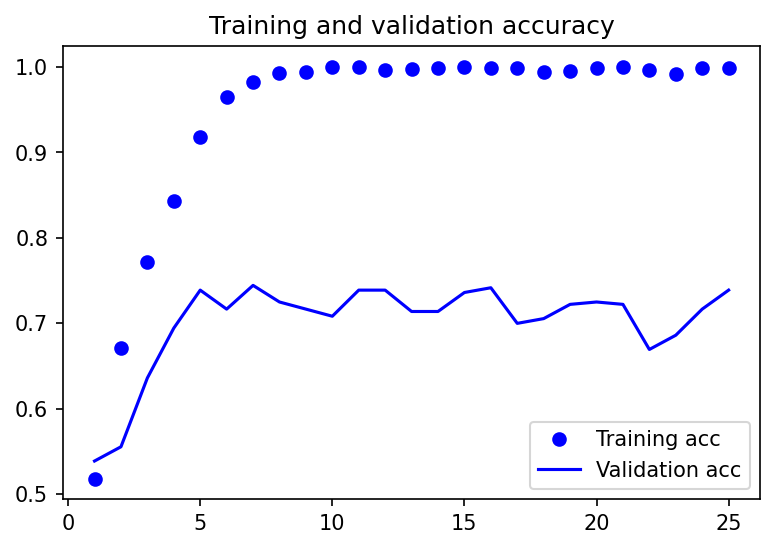

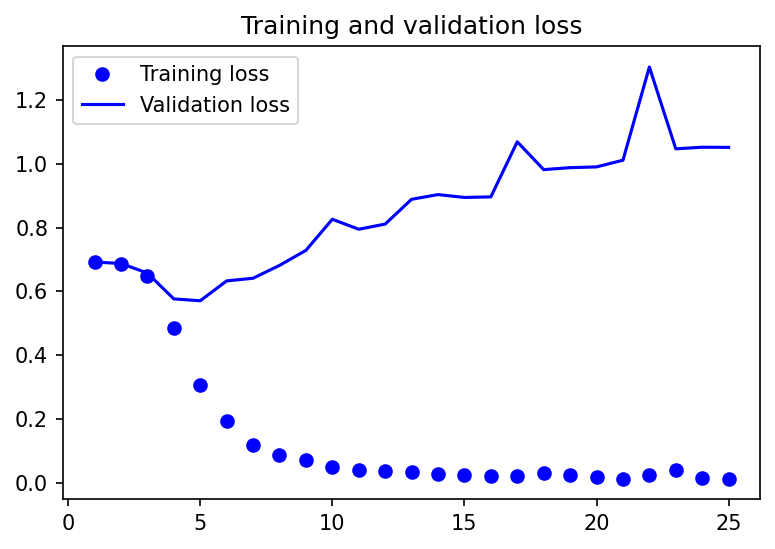

In [41]:
plot1(history4)

In [42]:
model4.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.9617 - accuracy: 0.7550


[0.9617339968681335, 0.7549999952316284]

### Model 5

- Embedding Layer + Bidirectional LSTM + Dense Layer
- Inputs: Text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.014.jpeg)

In [43]:
## Model 5
model5 = Sequential()
model5.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model5.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2)))
model5.add(Dense(1, activation="sigmoid"))

model5.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

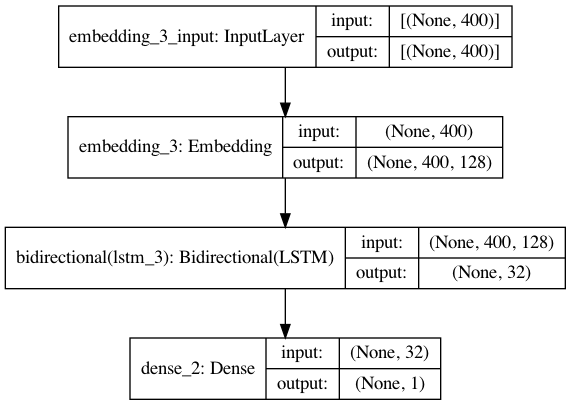

In [44]:
plot_model(model5, show_shapes=True)

In [45]:
history5 = model5.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25
12/12 - 14s - loss: 0.6920 - accuracy: 0.5368 - val_loss: 0.6901 - val_accuracy: 0.6222
Epoch 2/25
12/12 - 8s - loss: 0.6761 - accuracy: 0.8056 - val_loss: 0.6863 - val_accuracy: 0.6139
Epoch 3/25
12/12 - 9s - loss: 0.6470 - accuracy: 0.8826 - val_loss: 0.6775 - val_accuracy: 0.6000
Epoch 4/25
12/12 - 7s - loss: 0.5807 - accuracy: 0.9049 - val_loss: 0.6497 - val_accuracy: 0.6389
Epoch 5/25
12/12 - 7s - loss: 0.4219 - accuracy: 0.9222 - val_loss: 0.5724 - val_accuracy: 0.7361
Epoch 6/25
12/12 - 7s - loss: 0.2580 - accuracy: 0.9181 - val_loss: 0.5329 - val_accuracy: 0.7417
Epoch 7/25
12/12 - 8s - loss: 0.1361 - accuracy: 0.9833 - val_loss: 0.5240 - val_accuracy: 0.7694
Epoch 8/25
12/12 - 7s - loss: 0.0705 - accuracy: 0.9958 - val_loss: 0.5707 - val_accuracy: 0.7583
Epoch 9/25
12/12 - 7s - loss: 0.0465 - accuracy: 0.9993 - val_loss: 0.5409 - val_accuracy: 0.7833
Epoch 10/25
12/12 - 7s - loss: 0.0301 - accuracy: 1.0000 - val_loss: 0.5636 - val_accuracy: 0.7917
Epoch 11/25
12/12 

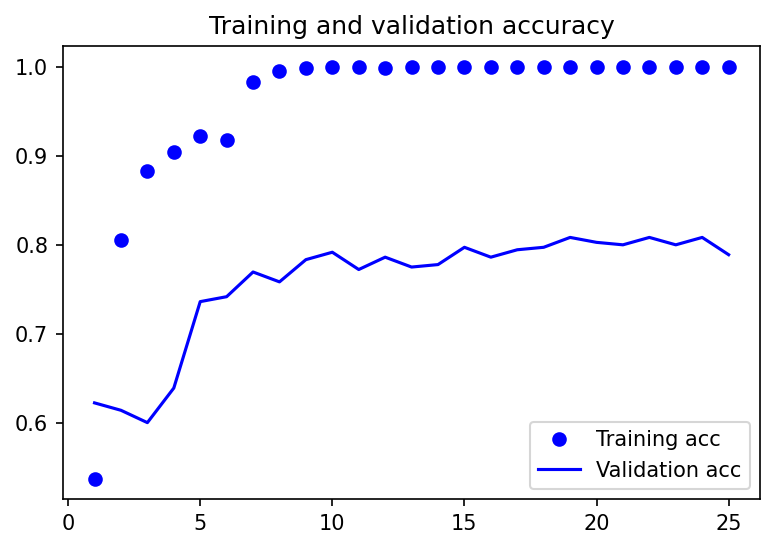

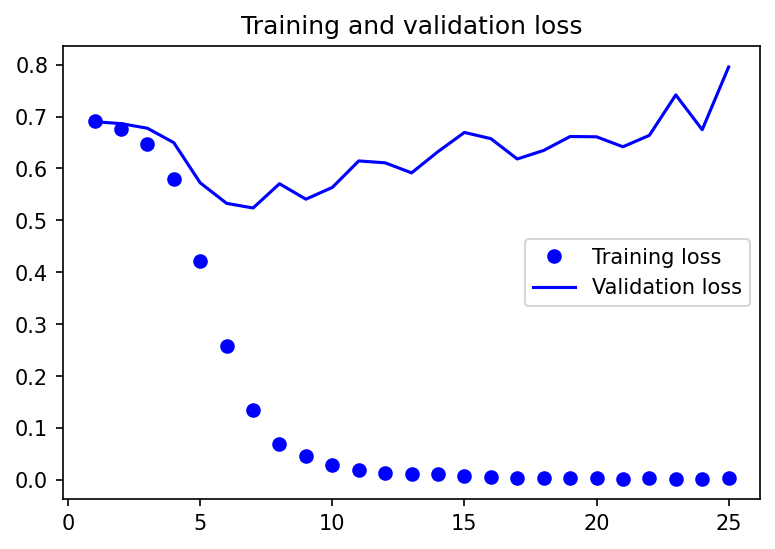

In [46]:
plot1(history5)

In [47]:
model5.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.6554 - accuracy: 0.8100


[0.6554412245750427, 0.8100000023841858]

## Even More Complex Sequence Models

### Model 6

- One Embedding Layer + LSTM [hidden state of last time step + cell state of last time step] + Dense Layer
- Inputs: Text sequences (padded)

![](../images/chris-olah/LSTM3-chain-annotated.jpeg)
(Source: https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.015.jpeg)

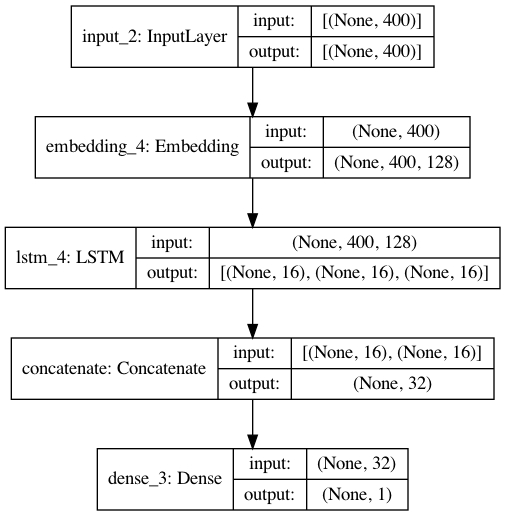

In [48]:
## Model 6

## Functional API
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
_, x_last_h, x_c = LSTM(16,
                        dropout=0.2,
                        recurrent_dropout=0.2,
                        return_sequences=False,
                        return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

x = Concatenate(axis=1)([x_last_h, x_c])
outputs = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs=inputs, outputs=outputs)

plot_model(model6, show_shapes=True)

In [49]:
model6.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history6 = model6.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6921 - accuracy: 0.5424 - val_loss: 0.6910 - val_accuracy: 0.5333
Epoch 2/25
12/12 - 5s - loss: 0.6729 - accuracy: 0.7646 - val_loss: 0.6875 - val_accuracy: 0.5528
Epoch 3/25
12/12 - 5s - loss: 0.6363 - accuracy: 0.8236 - val_loss: 0.6784 - val_accuracy: 0.5694
Epoch 4/25
12/12 - 4s - loss: 0.5368 - accuracy: 0.8278 - val_loss: 0.6685 - val_accuracy: 0.6111
Epoch 5/25
12/12 - 4s - loss: 0.3414 - accuracy: 0.9118 - val_loss: 0.6401 - val_accuracy: 0.6750
Epoch 6/25
12/12 - 4s - loss: 0.1908 - accuracy: 0.9667 - val_loss: 0.7364 - val_accuracy: 0.7111
Epoch 7/25
12/12 - 4s - loss: 0.1099 - accuracy: 0.9778 - val_loss: 0.6937 - val_accuracy: 0.7028
Epoch 8/25
12/12 - 4s - loss: 0.0709 - accuracy: 0.9889 - val_loss: 0.7784 - val_accuracy: 0.7194
Epoch 9/25
12/12 - 4s - loss: 0.0400 - accuracy: 0.9965 - val_loss: 0.8622 - val_accuracy: 0.7333
Epoch 10/25
12/12 - 4s - loss: 0.0265 - accuracy: 0.9958 - val_loss: 0.8666 - val_accuracy: 0.7139
Epoch 11/25
12/12 -

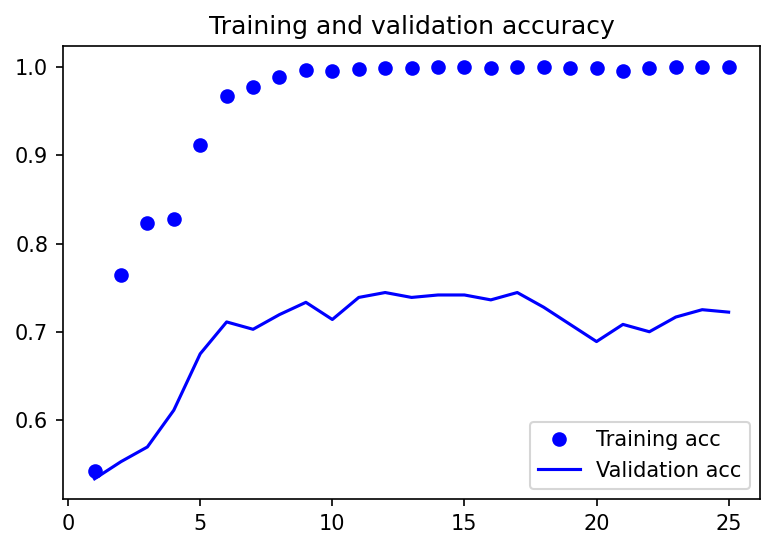

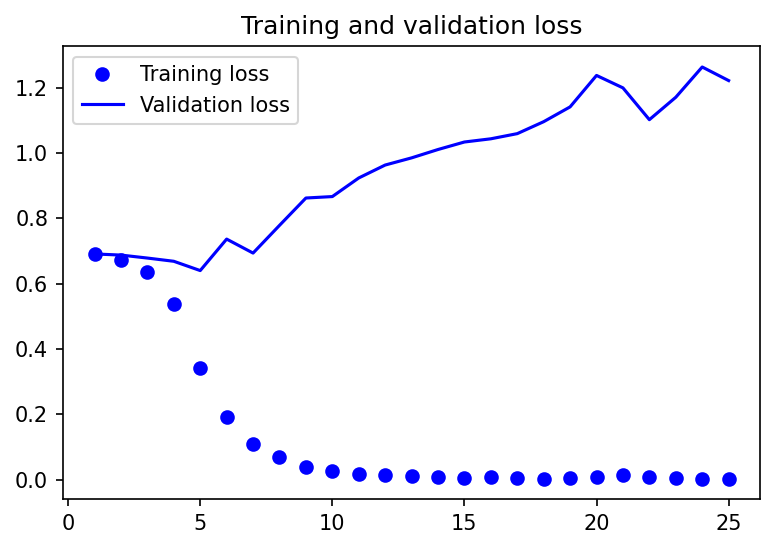

In [50]:
plot1(history6)

In [51]:
model6.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.9593 - accuracy: 0.7600


[0.9593116641044617, 0.7599999904632568]

### Model 7

- Embedding + LSTM + Self-Attention + Dense
- Inputs: Text sequences

- All of the previous RNN-based models only utilize the output of the **last time step** from the RNN as the input of the decision-making Dense layer.
- We can also make **all the hidden outputs** at all time steps from the RNN available to decision-marking Dense layer.
- This is the idea of **Attention**.

![](../images/seq2seq-self-atten.gif)

- Here we add one `Self-Attention` layer, which gives us a weighted version of all the hidden states from the RNN.
- Self Attention layer is a simple sequence-to-sequence layer, which takes in a set of input tensors and returns a set of output tensors. 
- In Self Attention Layer, each output vector is transformed by considering the pairwise similarities of its corresponding input vector and all the other input vectors. 
- We will come back to the Attention mechanism in the later unit for more details.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.016.jpeg)

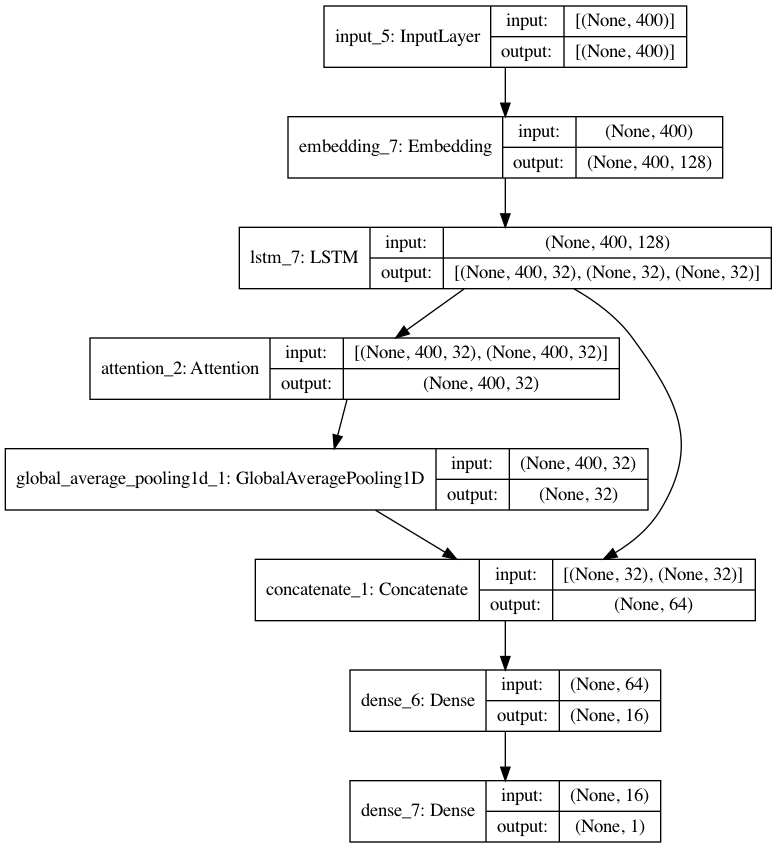

In [73]:
## Model 7 (Self-Attention)

inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
x_all_hs, x_last_h, x_last_c = LSTM(32,
                                    dropout=0.2,
                                    recurrent_dropout=0.2,
                                    return_sequences=True,
                                    return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

## Self Attention
atten_out = Attention()([x_all_hs, x_all_hs])  # query and key
atten_out_average = GlobalAveragePooling1D()(atten_out)

x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
x = Dense(16, activation="relu")(x_last_h_plus_atten)
outputs = Dense(1, activation='sigmoid')(x)
model7 = Model(inputs=inputs, outputs=outputs)

plot_model(model7, show_shapes=True)

In [74]:
# ## Model 7 (Attention of lasth on allh)

# inputs = Input(shape=(max_len,))
# x = Embedding(input_dim=vocab_size,
#               output_dim=EMBEDDING_DIM,
#               input_length=max_len,
#               mask_zero=True)(inputs)
# x_all_hs, x_last_h, x_last_c = LSTM(32,
#                                     dropout=0.2,
#                                     recurrent_dropout=0.2,
#                                     return_sequences=True,
#                                     return_state=True)(x)
# ## LSTM Parameters:
# #     `return_seqeunces=True`: return the hidden states for each time step
# #     `return_state=True`: return the cell state of the last time step
# #     When both are set True, the return values of LSTM are:
# #     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
# #     (2) the hidden state of the last time step
# #     (3) the cell state of the last time step

# ## Self Attention
# atten_out = Attention()([x_last_h, x_all_hs])  # Attention of last hidden states on all preceding states
# atten_out_average = layers.GlobalMaxPooling1D()(atten_out)

# x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
# x = Dense(16, activation="relu")(x_last_h_plus_atten)
# outputs = Dense(1, activation='sigmoid')(x)
# model7 = Model(inputs=inputs, outputs=outputs)

# plot_model(model7, show_shapes=True)

In [75]:
# ## Model 7 (Self-Attention before RNN)

# inputs = Input(shape=(max_len, ))
# x = Embedding(input_dim=vocab_size,
#               output_dim=EMBEDDING_DIM,
#               input_length=max_len,
#               mask_zero=True)(inputs)

# atten_out = Attention()([x,x])

# x_all_hs, x_last_h, x_last_c = LSTM(32,
#                                     dropout=0.2,
#                                     recurrent_dropout=0.2,
#                                     return_sequences=True,
#                                     return_state=True)(atten_out)
# ## LSTM Parameters:
# #     `return_seqeunces=True`: return the hidden states for each time step
# #     `return_state=True`: return the cell state of the last time step
# #     When both are set True, the return values of LSTM are:
# #     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
# #     (2) the hidden state of the last time step
# #     (3) the cell state of the last time step

# x = Dense(16, activation="relu")(x_last_h)
# outputs = Dense(1, activation='sigmoid')(x)
# model7 = Model(inputs=inputs, outputs=outputs)

# plot_model(model7, show_shapes=True)

In [76]:
model7.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history7 = model7.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 15s - loss: 0.6927 - accuracy: 0.5250 - val_loss: 0.6917 - val_accuracy: 0.5917
Epoch 2/25
12/12 - 9s - loss: 0.6849 - accuracy: 0.6417 - val_loss: 0.6871 - val_accuracy: 0.5667
Epoch 3/25
12/12 - 9s - loss: 0.6584 - accuracy: 0.7563 - val_loss: 0.6720 - val_accuracy: 0.5889
Epoch 4/25
12/12 - 9s - loss: 0.5557 - accuracy: 0.8236 - val_loss: 0.5987 - val_accuracy: 0.6667
Epoch 5/25
12/12 - 9s - loss: 0.3430 - accuracy: 0.9229 - val_loss: 0.5011 - val_accuracy: 0.7889
Epoch 6/25
12/12 - 10s - loss: 0.1586 - accuracy: 0.9708 - val_loss: 0.5863 - val_accuracy: 0.7417
Epoch 7/25
12/12 - 9s - loss: 0.1138 - accuracy: 0.9736 - val_loss: 0.6716 - val_accuracy: 0.7111
Epoch 8/25
12/12 - 9s - loss: 0.0591 - accuracy: 0.9889 - val_loss: 0.7051 - val_accuracy: 0.7306
Epoch 9/25
12/12 - 9s - loss: 0.0596 - accuracy: 0.9840 - val_loss: 0.7922 - val_accuracy: 0.6889
Epoch 10/25
12/12 - 9s - loss: 0.0350 - accuracy: 0.9931 - val_loss: 0.7905 - val_accuracy: 0.7528
Epoch 11/25
12/12

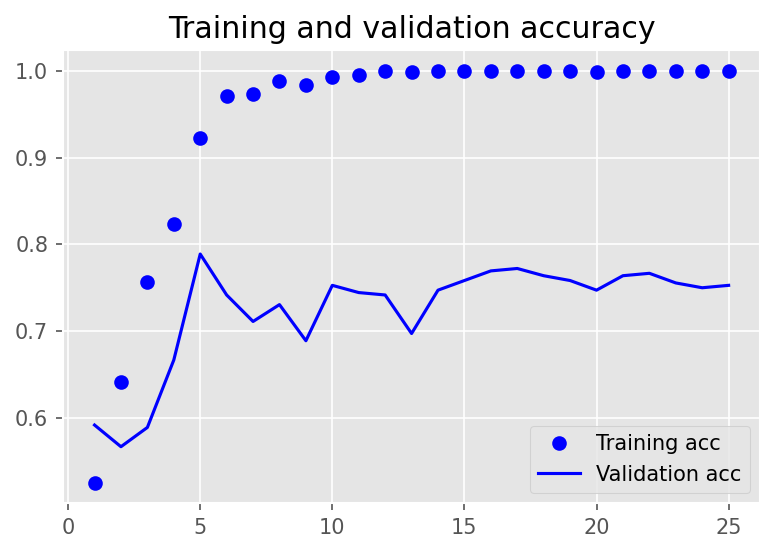

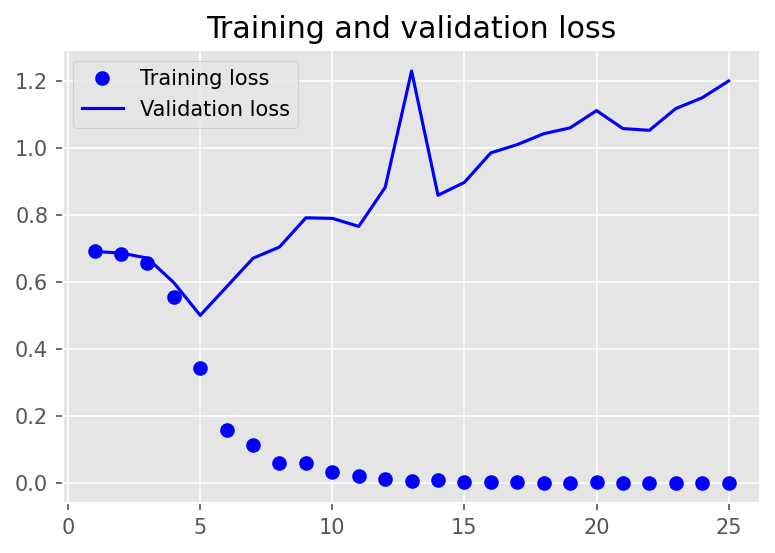

In [77]:
plot1(history7)

In [78]:
model7.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.9693 - accuracy: 0.7950


[0.9692936539649963, 0.7950000166893005]

## Explanation

- We use LIME for model explanation.
- Let's inspect the Attention-based Model (model7).

:::{warning}
In our current experiments, we have not considered very carefully the issue of model over-fitting. To optimize the network, it is necessary to include **regularization** and **dropouts** to reduce the variation of the model performance on unseen datasets (i.e., **generalization**).
:::

In [79]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'],
                              char_level=False)

## Select the best model so far
best_model = model7

In [80]:
## Pipeline for LIME
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    return np.array([[float(1 - x), float(x)]
                     for x in best_model.predict(np.array(_seq_pad))])

In [81]:
text_id = 3
exp = explainer.explain_instance(X_test_texts[text_id],
                                 model_predict_pipeline,
                                 num_features=20,
                                 top_labels=1)
exp.show_in_notebook(text=True)

In [82]:
exp.show_in_notebook(text=True)

## Check Embeddings

- We can also examine the word embeddings learned along with our Classifier.
- Steps include:
    - Extract the embedding weights from the trained model.
    - Determine words we would like to inspect.
    - Extract the embeddings of these words.
    - Use dimensional reduction techniques to plot word embeddings in a 2D graph.

In [83]:
word_vectors = best_model.layers[1].get_weights()[0]
word_vectors.shape

(10001, 128)

In [84]:
## Mapping of embeddings and word-labels
token_labels = [
    word for (ind, word) in tokenizer.index_word.items()
    if ind < word_vectors.shape[0]
]
token_labels.insert(0, "PAD")
token_labels[:10]

['PAD', 'the', 'a', 'and', 'of', 'to', "'", 'is', 'in', 's']

In [85]:
len(token_labels)

10001

- Because there are many words, we select words for visualization based on the following criteria:
    - Include embeddings of words that are not on the English stopword list (`nltk.corpus.stopwords.words('english')`) and whose word length >= 5 (characters)

In [86]:
from sklearn.manifold import TSNE
stopword_list = nltk.corpus.stopwords.words('english')

In [87]:
out_index = [
    i for i, w in enumerate(token_labels)
    if len(w) >= 5 and w not in stopword_list
]
len(out_index)

8209

In [88]:
out_index[:10]

[27, 69, 70, 73, 81, 83, 91, 97, 100, 103]

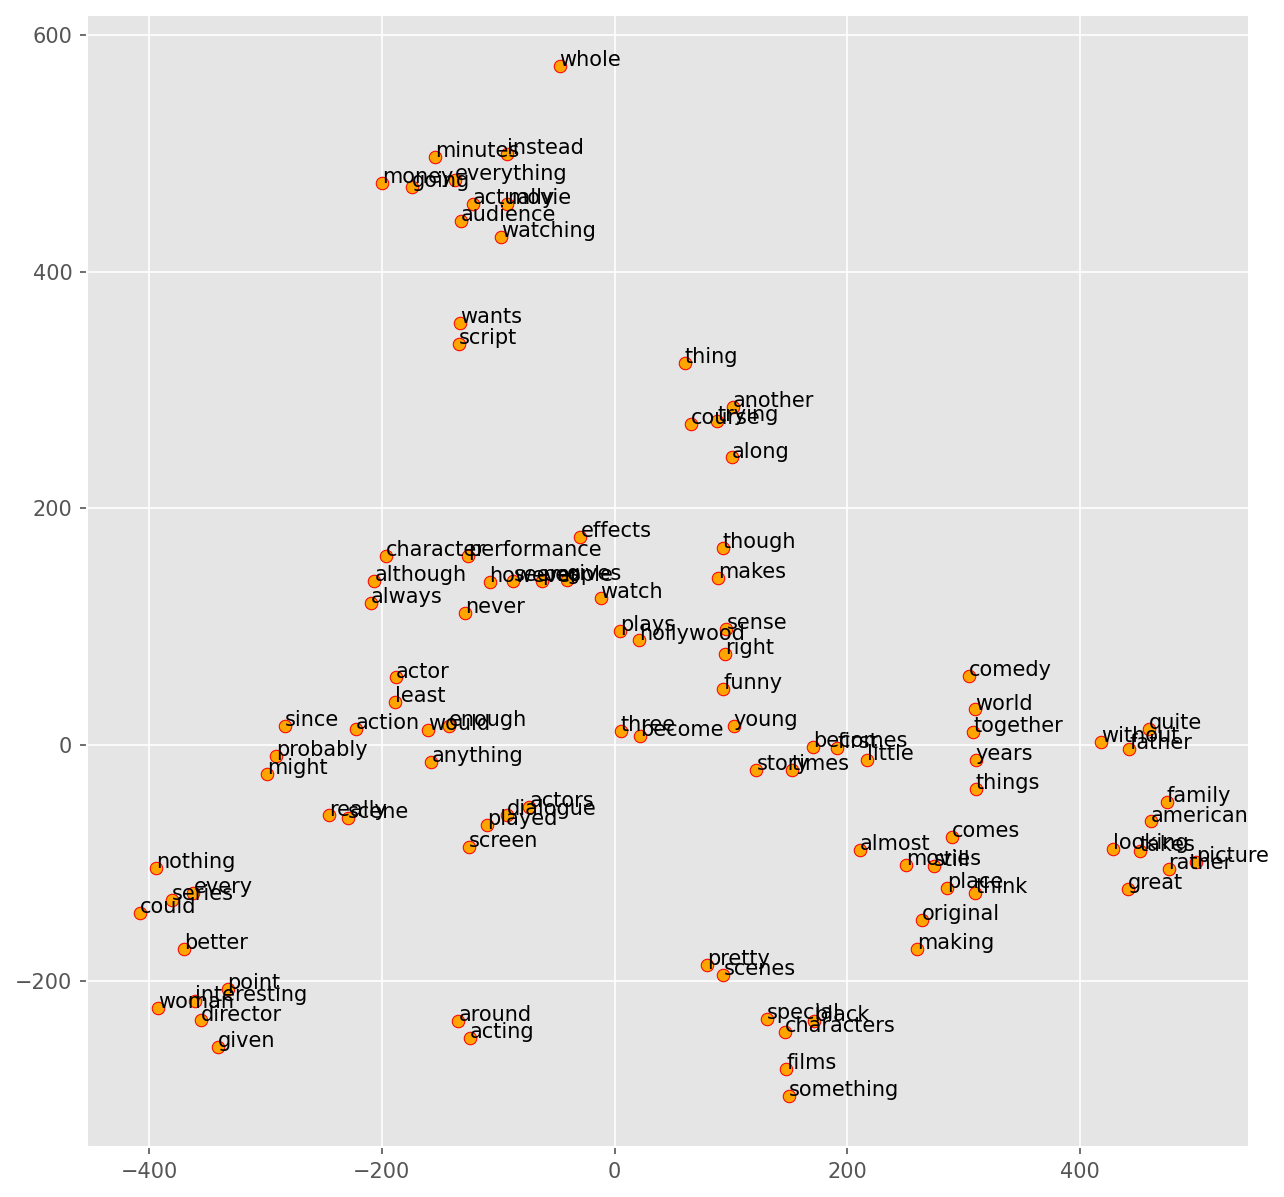

In [89]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors[out_index[:100], ])
labels = list(np.array(token_labels)[out_index[:100]])

len(labels)

plt.figure(figsize=(10, 10), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 0.01, y + 0.01),
                 xytext=(0, 0),
                 textcoords='offset points')

## Model Comparisons

- Let's compare the learning performance of all the models by examining their changes of accuracies and losses in each epoch of training.

In [90]:
history = [
    history1, history2, history3, history4, history5, history6, history7
]
history = [i.history for i in history]
model_names = [
    'One-hot-dense', 'Embedding-dense', 'RNN', 'Two-RNN', 'Bidirect',
    'Hidden-Cell', 'Self-attention'
]

## Set color pallete
import seaborn as sns
qualitative_colors = sns.color_palette("Paired", len(history))

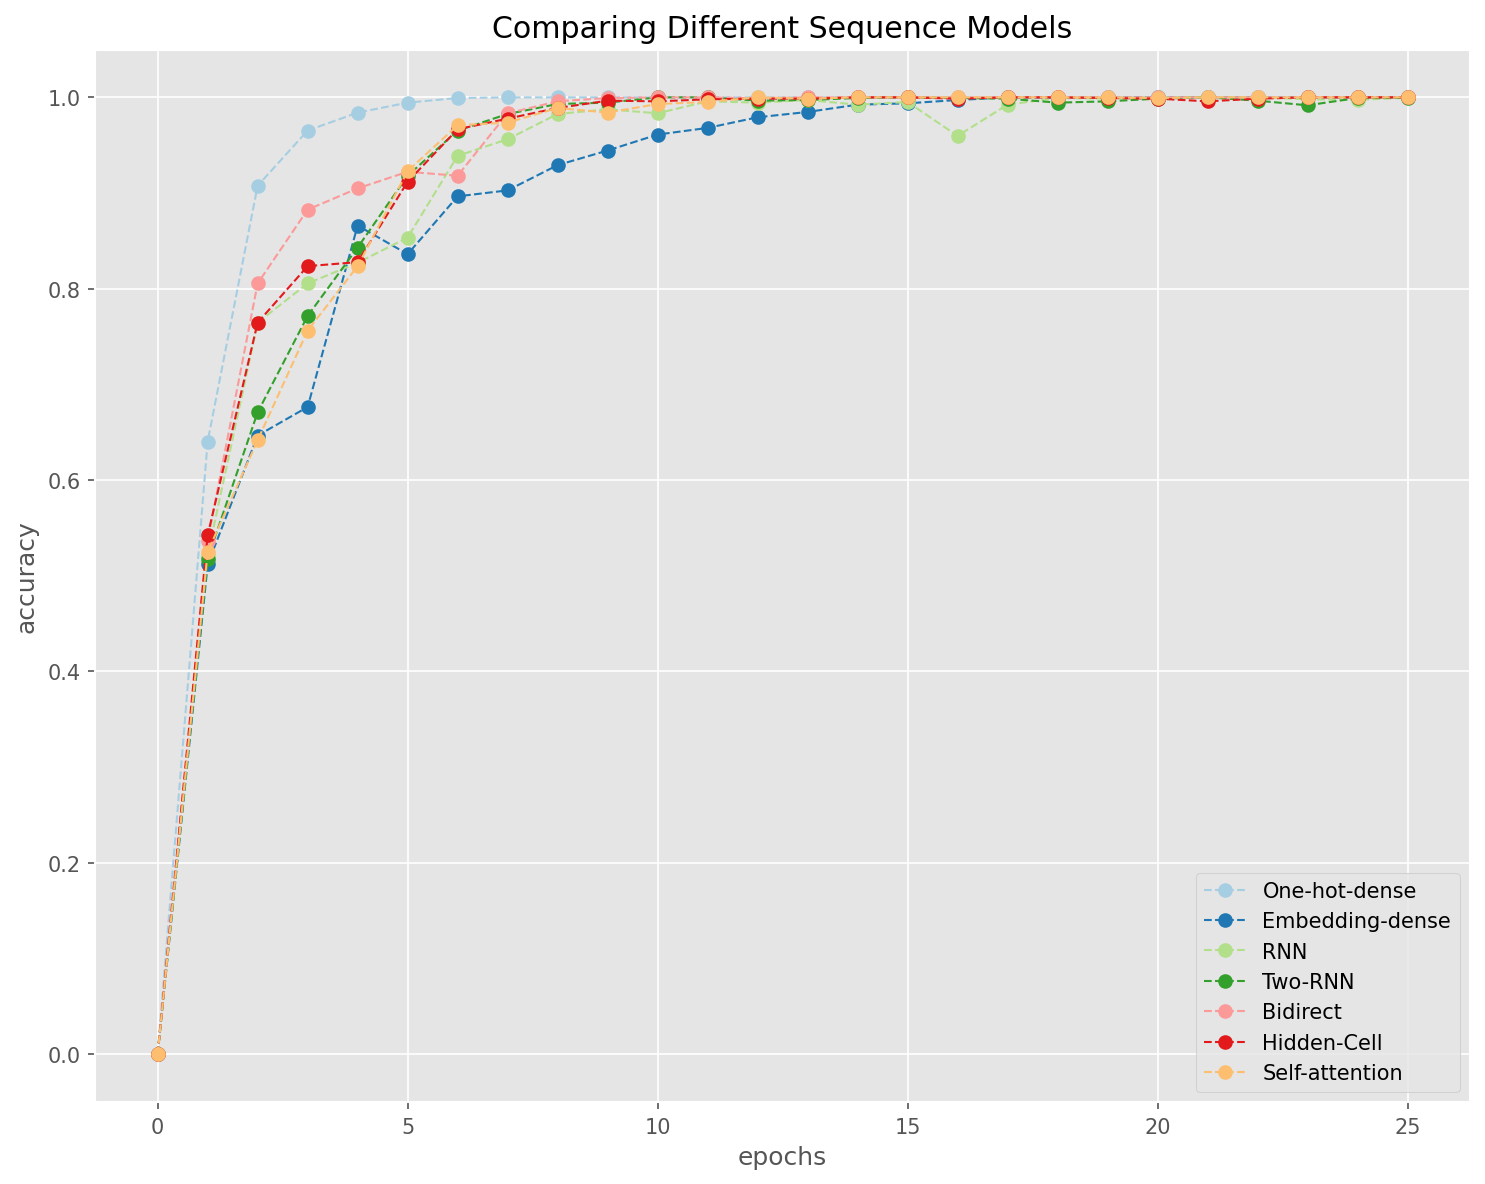

In [91]:
## Accuracy
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(acc):
    plt.plot(range(len(a) + 1), [0] + a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

- General Observations
    - Fully-connected network works better with one-hot encoding of texts (i.e., bag-of-words vectorizaed representations of texts)
    - Embeddings are more useful when working with sequence models (e.g., RNN).
    - The self-attention layer, in our current case, is on the entire input sequence, and therefore is limited in its effects.

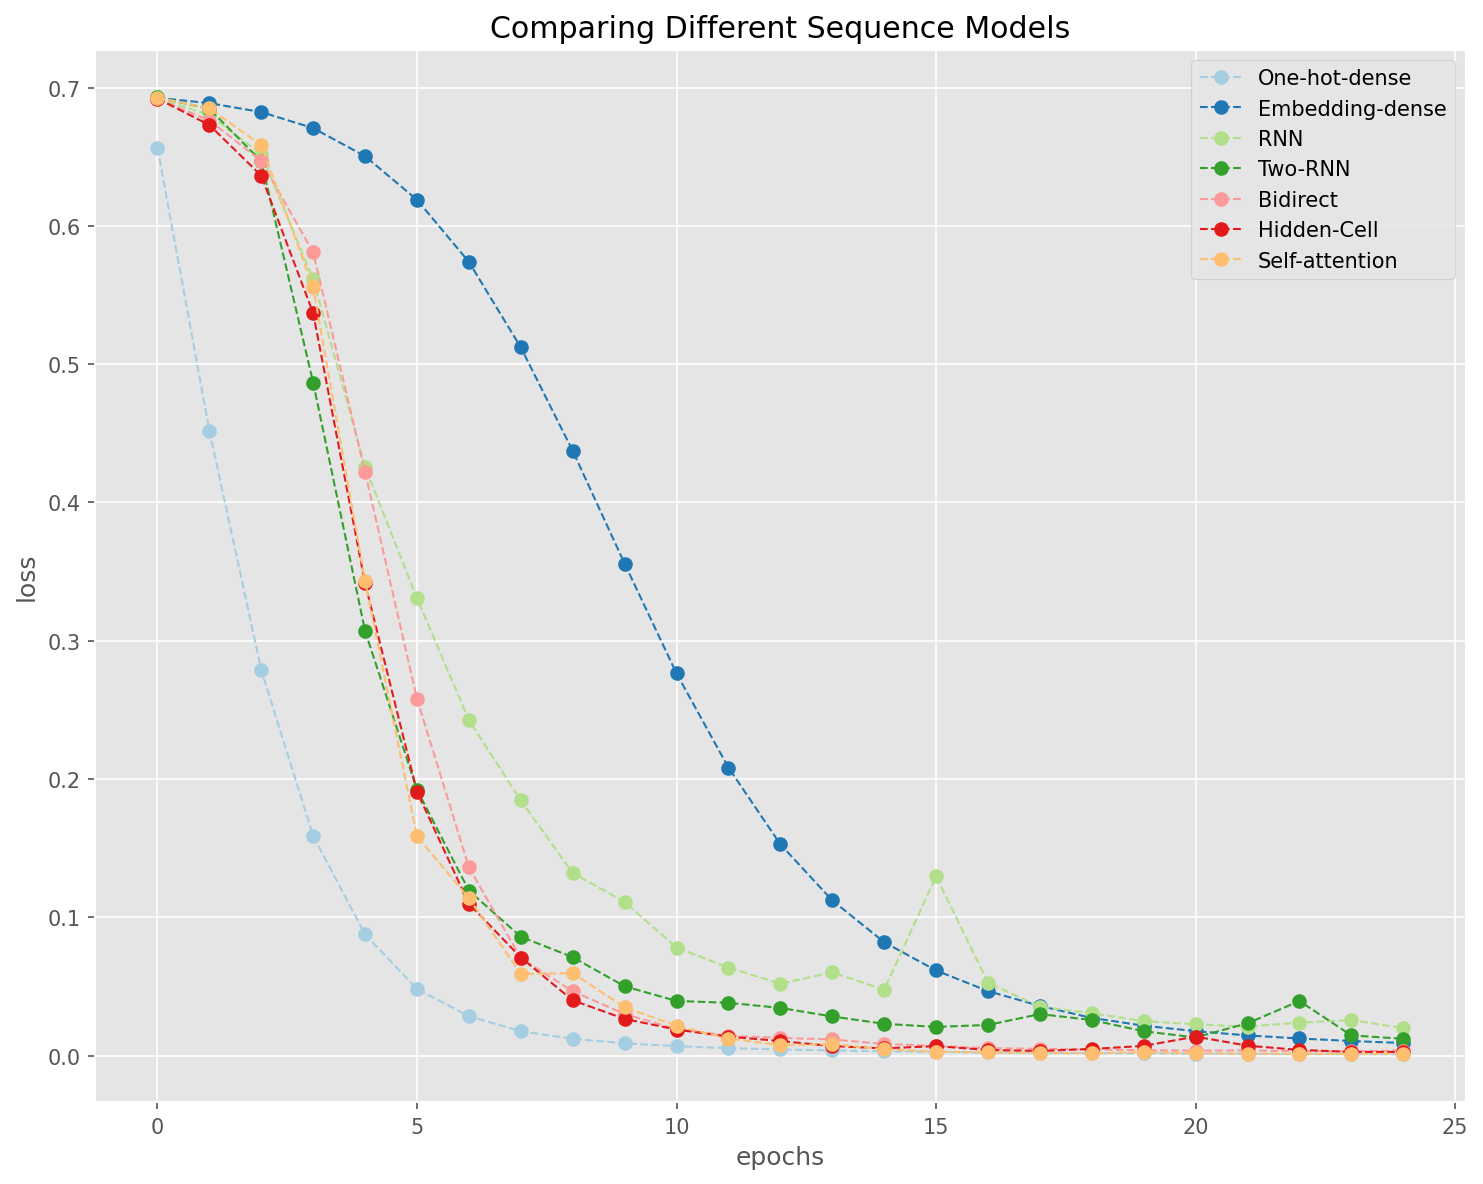

In [92]:
loss = [i['loss'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),
             a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()